# Evolution generation of terrain

Tento script slouží ke generaci podle uričtých kritérii.

### Instalace kinhoven

1. vytvoření virtuálního prostředí
```bash
py -m venv .venv
```
2. instalace knihoven
```bash
pip install -r requirements.txt
```

### Technologie
Využívájí se technologie [DEAP](https://deap.readthedocs.io/en/master/overview.html) a [numpy](https://numpy.org/doc/stable/) a [matplotlib](https://matplotlib.org/stable/index.html)

### Důležité Definice
1. Vrcholek je bod terénu, jehož levý a pravý soused (předchozí a následující bod) jsou nižší
2. Úroveň vody je konstantní přes celý terén a jedná se o hodnotu 0.5
3. Jezero je část terénu pod hodnotou 0.5 a nejnižší bod je vyšší než 0.4
4. Moře je část terénu pod hodnotou 0.5 (nejnižší bod není omezen)

### Kritéria evoluce
1. Počet vrcholků
2. Počet jezer
3. Počet moří
4. Procento terénu pod vodou
5. Variabilita
6. Drsnost terénu

## Užité funkce

#### plotterrain(t)

Funkce, která vykresluje terén. Přebírá list float čísel (mezi 0.0 a 1.0), která reprezentují body terénu.

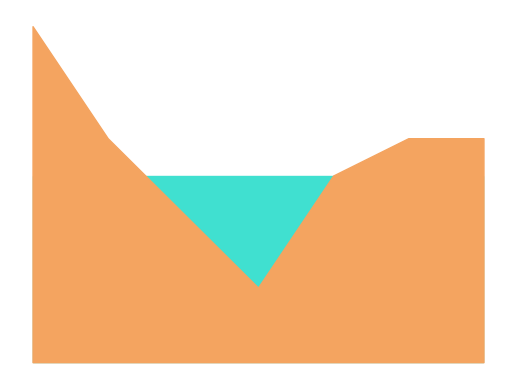

In [3]:
import matplotlib.pyplot as plt

def plotterrain(t):
    """
    Terrain is a list of float numbers between 0 and 1, and water level is 0.5

    :param t: list of float numbers representing the terrain
    :return: None
    """

    fig, ax = plt.subplots()

    x = range(len(t))
    sea = [0.5 for i in range(len(t))]

    ax.fill_between(x, sea, color="turquoise")
    ax.fill_between(x, t, color="sandybrown")

    plt.axis("off")
    plt.show()

# example
terrain = [0.9, 0.6, 0.4, 0.2, 0.5, 0.6, 0.6]
plotterrain(terrain)


### Funkce použité pro evoluční fitness funkci
Tyto funkce slouží jako kritéria pro posouzení potomka evoluce, zda-li se jedná o kvalitního či nekvalitního potomka.

#### count_peaks(t)
Funkce count peaks dostane jako parametr body terénu a vrátí počet vrcholků odpovídající definici

In [5]:
def count_peaks(t):
    """
    Used to count the number of peaks in the terrain.
    The definition of a peak is on the line #6

    :param t: list of floats that represents points in the terrain
    :return: number of peaks in the terrain
    """
    count = 0
    for i in range(len(t)):

        # edge case 1 --> first point in terrain
        if i == 0 and t[i] > t[i + 1]:
            count += 1

        # edge case 2 --> last point in terrain
        elif i == len(t) - 1 and t[i] > t[i - 1]:
            count += 1

        # point in terrain
        elif 0 < i <len(t) and t[i-1] < t[i] > t[i+1]:
            count += 1

    return count

terrain_1 = [0.9, 0.6, 0.4, 0.2, 0.5, 0.7, 0.6] # expected output: 2 -> points 0.9 and 0.7 are peaks
print(f"Output num.1 : {count_peaks(terrain)}")

terrain_2 = [0.5, 0.7, 0.7, 0.7, 0.5] # expected output: 0 -> no peaks all flatlands
print(f"Output num.2 : {count_peaks(terrain_2)}")

Output num.1 : 2
Output num.2 : 0


#### count_lakes_seas(t)
Funkce spočítá kolik se nachází v terénu jezer a moří podle definice

In [6]:
def count_lakes_seas(t):
    """
    Used to count the number of lakes and seas in the terrain.
    Definitions of lake and sea in this program is on line #8 and #9

    :param t: list of floats that represents points in the terrain
    :return: number of lakes and seas in the terrain
    """
    lake_count = 0
    sea_count = 0
    in_water = False
    min_height = 1.0

    for height in t:
        if not in_water and height <= 0.5:  # entering water
            in_water = True
            min_height = height  # start tracking minimum height
        elif in_water:
            if height <= 0.5:  # still in water
                min_height = min(min_height, height)  # update minimum height
            else:  # exiting water
                # classify water body based on minimum height
                if min_height < 0.4:
                    sea_count += 1
                else:
                    lake_count += 1
                in_water = False

    # edge case -> terrain ends while still in water
    if in_water:
        if min_height < 0.4:
            sea_count += 1
        else:
            lake_count += 1

    return lake_count, sea_count

# examples
terrain_3 = [0.9, 0.6, 0.4, 0.2, 0.5, 0.7, 0.6] # expected output: 0, 0 -> no lakes and no seas
lake, seas = count_lakes_seas(terrain)
print(f"Output num.3 : sea count: {seas}, lake count: {lake}")

terrain_4 = [0.6, 0.2, 0.4, 0.7, 0.5, 0.4, 0.8] # expected output: 1, 1 -> one lake and one seas
lake, seas = count_lakes_seas(terrain_2)
print(f"Output num.4 : sea count: {seas}, lake count: {lake}")


Output num.3 : sea count: 1, lake count: 0
Output num.4 : sea count: 1, lake count: 1


#### water_coverage(t)
Velmi jednoduchá funkce, která vrací kolik procent terénu je pod hladinou vody (viz. definice)

In [ ]:
def water_coverage(t):
    """
    Used to calculate how much land is underwater

    :param t: list of floats that represents points in the terrain
    :return: percentage of water coverage
    """
    # water level is 0.5
    water_level = 0.5
    return sum(1 for i in t if i < water_level) / len(t)

# example
terrain_5 = [0.9, 0.6, 0.4, 0.2, 0.5, 0.7, 0.6] # expected output: 0.4 -> 40% of terrain is underwater
print(f"Output num.5 : {water_coverage(terrain):.2f}%")

terrain_6 = [0.3, 0.2, 0.1, 0.4, 0.2] # expected output: 1 -> 100% of terrain is underwater
print(f"Output num.6 : {water_coverage(terrain_6):.2f}%")

#### terrain_variability(t)
Funkce vrací deviaci v terénu.


In [7]:
import numpy as np

def terrain_variability(t):
    """
    :param t: list of floats that represents points in the terrain
    :return: Returns the standard deviation of the terrain
    """
    return np.std(t)

# example
terrain_7 = [0.9, 0.5, 0.4, 0.6, 0.5, 0.7, 0.6] # expected output: 0.15 -> terrain has low variability
print(f"Output num.7 : {terrain_variability(terrain_7):.2f}")

terrain_8 = [0.1, 1.0, 0.3, 0.9, 0.3, 1.0] # expected output: 0.37 -> terrain has high variability
print(f"Output num.8: {terrain_variability(terrain_8):.2f}")

Output num.7 : 0.15
Output num.8: 0.37


#### terrain_roughness(t)
Funkce vrací průměrný rozdíl mezi dvoumi sousedícími body.

In [10]:
def terrain_roughness(t):
    """
    Used to determine the terrain roughness

    :param t: list of floats that represents points in the terrain
    :return: average difference between two neighboring points
    """
    return sum(abs(t[i] - t[i-1]) for i in range(1, len(t))) / (len(t)-1)

# example
terrain_9 = [0.3, 0.2, 0.3, 0.4, 0.5, 0.9] # expected output: 0.16 -> terrain has low roughness
print(f"Output num.9 : {terrain_roughness(terrain_9):.2f}")

terrain_10 = [0.1, 1.0, 0.1, 0.9, 0.2, 1.0] # expected output: 0.82 -> terrain has high roughness
print(f"Output num.10 : {terrain_roughness(terrain_10):.2f}")

Output num.9 : 0.16
Output num.10 : 0.82


### Vyhodnovací funkce
Tato funkce kombinuje veškerá kritéria plus jednu další aby zjistila jak moc dobrý je daný potomek (terén). Přidal jsem ještě jedno kritérium, které zamezuje příliš velkým vrcholkům, jelikož to tvořilo velmi nepěknou krajinu. Funkce vrací tuple desetinnéh čísla v intervalo (-infinit, 0>. Jelikož chceme maximalizovat fitness potomka chceme co nejvyšší číslo. Pozn. Funkce vrací tuple jelikož tak požaduje funkce knihovny DEAP


In [13]:
from main import count_peaks, count_lakes_seas, water_coverage, terrain_variability, terrain_roughness

def evaluate(terrain):
    peaks = count_peaks(terrain)
    lakes, seas = count_lakes_seas(terrain)
    coverage = water_coverage(terrain)
    variability = terrain_variability(terrain)
    roughness = terrain_roughness(terrain)

    # punish high peaks
    peak_penality = sum(1 for h in terrain if h > 0.8) * -0.5

    # Goals: 3-4 peaks, 2–3 lakes, 1-2 seas, 60% water, moderate variability, smoothness
    peak_score = -abs(peaks - 3.5) # best if ~3-4 peaks
    lake_score = -abs(lakes - 2.5)  # best if ~2–3 lakes
    sea_score = -abs(seas - 1.5) # best if ~1–2 seas
    water_score = -abs(coverage - 0.6)  # best if ~60% flooded
    var_score = -abs(variability - 0.15)  # ideal variability
    rough_score = -abs(roughness - 0.2)   # ideal roughness

    return peak_score + lake_score + sea_score + water_score + var_score + rough_score + peak_penality,

# example
terrain_11 = [0.8, 0.2, 0.4, 0.6, 0.5, 0.4, 0.7, 0.4, 0.4, 0.6]
"""
expected output: -1.6 --> relatively good terrain
peaks: 4
lakes: 2
seas: 1
coverage: 50%
variability: 0.17
roughness: 0.22
"""
print(f"Output num.11 : {evaluate(terrain_11)}")


Output num.11 : (-1.6395542275290373,)
